# Create tags with unsupervised and supervised learning

In [2]:
#importation des librairies

import pandas as pd #data processing
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pprint import pprint

#NLTK
import nltk #natural language toolkit
#nltk.download()
from nltk import word_tokenize,sent_tokenize
from nltk.corpus import stopwords # Import the stop word list
#nltk.download()

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
import pyLDAvis.gensim 

from bs4 import BeautifulSoup #to remove HTML Markup

import re #for regular expression

from nltk.stem import SnowballStemmer #Stemmming

#create matrix of words frequency
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn import model_selection
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
#from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn import metrics
#from sklearn.metrics import accuracy_score

#save model on computer
from sklearn.externals import joblib

***

In [2]:
# import data
df1 = pd.read_csv('/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/QueryResults(1).csv',encoding = 'utf-8')
df2 = pd.read_csv('/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/QueryResults(2).csv',encoding = 'utf-8')
df3 = pd.read_csv('/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/QueryResults(3).csv',encoding = 'utf-8')

In [ ]:
#concatenat the 3 data base
df = pd.concat([df1, df2, df3], ignore_index=True)
print(df.shape)

In [3]:
df1=0
df2=0
df3=0

In [ ]:
#Names of the columns
df.columns.values

In [ ]:
df.head()

***

# Cleanning the dataset

In [ ]:
# get rid of duplicates rows
df= df.drop_duplicates()
print(df.shape)

In [ ]:
df = df.head(50000)

In [ ]:
df.isnull().sum()

In [ ]:
df.reset_index(drop=True, inplace=True)

In [ ]:
df.Score.max()

* Join Title and body

In [ ]:
#join title and body for each question in a new column
# name "text"
df['Text'] = df[['Title', 'Body']].apply(lambda x: ' '.join(x), axis=1)

In [297]:
df["Text"].isnull().sum()

0

***

***

* Text column : Data cleaning and text processing

In [289]:
stop_words = stopwords.words('english')
#add some more words
stop_words.extend(['use','get', 'like', 'work', 'name', 'want', 'need', 'would', 'know', 'x', 'l', 'b', 'e'])

***

# Unsupervised learning

***

# With sklearn

## Creating Features from a Bag of Words With CountVectrizer

Max words : 5000

In [44]:
def text_to_words( raw_text ):
    # Function to convert the text cell to a string of words
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_text, 'html.parser').get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()
    words = [wds for wds in words if ((wds!='.') & (wds!='+') & (wds!='#') & (wds!='-'))]
    # 
    # 4. Stemming
    snowball_stemmer = SnowballStemmer('english')
    meaningful_wordsStem = [snowball_stemmer.stem(w) for w in words]
    #
    # 5. Remove stop words
    meaningful_words = [w for w in meaningful_wordsStem if not w in stop_words]
    #
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    return( " ".join(meaningful_words))
    #return meaningful_words

In [353]:
# Get the number of questions based on the dataframe column size
num_questions = df["Text"].size
#num_questions = 5000
# Initialize an empty list to hold the clean questions
clean_train_questions_Join = []

print("Cleaning and parsing the training...\n")
# Loop over each row; create an index i that goes from 0 to the length
# of the questions list 
for i in range(0, num_questions):
    # Call our function for each one, and add the result to the list of
    # clean questions
    clean_train_questions_Join.append( text_to_words( df["Text"][i] ) )

Cleaning and parsing the training...



In [273]:
print("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 10000) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features_NA = vectorizer.fit_transform(clean_train_questions_Join)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features_NA.toarray()

Creating the bag of words...



In [133]:
print(train_data_features.shape)

(50000, 5000)


In [274]:
vocab = vectorizer.get_feature_names()
#print(vocab)

In [275]:
# Sum up the counts of each vocabulary word
dist = np.sum(train_data_features, axis=0)

# For each, print the vocabulary word and the number of times it 
# appears in the training set
#for tag, count in zip(vocab, dist):
#    print(count, tag)

In [276]:
dfFrequence = pd.DataFrame()
dfFrequence['Mots'] = vocab
dfFrequence['occurrence'] = dist

In [277]:
dfFrequence.sort_values(by=['occurrence'], inplace=True, ascending=False)

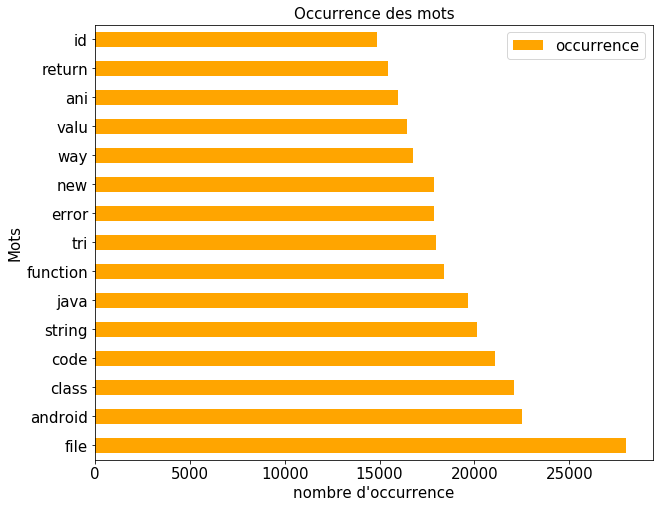

In [279]:
dfFrequence.head(15).plot(kind = 'barh', x = dfFrequence.head(15)['Mots'], figsize = (10,8), color = 'orange')
plt.xlabel("nombre d'occurrence")
plt.title('Occurrence des mots', size = 15)
plt.rcParams.update({'font.size': 15})
plt.show()

In [146]:
dfFrequence.occurrence.describe()

count     5000.000000
mean       677.743000
std       1733.495213
min         43.000000
25%         70.000000
50%        141.000000
75%        461.250000
max      28013.000000
Name: occurrence, dtype: float64

* Max word : 100

In [162]:
print("Creating the bag of words...\n")

# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 100) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
train_data_features_NA = vectorizer.fit_transform(clean_train_questions_Join)

# Numpy arrays are easy to work with, so convert the result to an 
# array
train_data_features = train_data_features_NA.toarray()

Creating the bag of words...



In [ ]:
print(train_data_features.shape)

In [163]:
vocab = vectorizer.get_feature_names()
dist = np.sum(train_data_features, axis=0)

In [164]:
dfFrequence = pd.DataFrame()
dfFrequence['Mots'] = vocab
dfFrequence['occurrence'] = dist
dfFrequence.sort_values(by=['occurrence'], inplace=True, ascending=False)

In [165]:
dfFrequence.head()

,Mots,occurrence
26,file,28013
2,android,22491
10,class,22106
11,code,21072
79,string,20128


In [166]:
dfFrequence.loc[(dfFrequence['Mots'] == 'python')]

,Mots,occurrence
64,python,8063


In [168]:
dfFrequence.occurrence.describe()

count      100.000000
mean     10169.570000
std       4554.795642
min       5886.000000
25%       6763.750000
50%       8566.000000
75%      12637.000000
max      28013.000000
Name: occurrence, dtype: float64

* Creating Features from a Bag of Words With TfidfTransformer

In [101]:
print("Creating the bag of words...\n")

#calculate the tf-idf weights for our term frequency matrix

# Initialize the "TfidfTransformer" object, with L2 norme
#which is the default value
tfidf_vectorizer = TfidfTransformer(norm="l2") 

# fit_transform() On the data from CountVectorizer
tfidfMatrix = tfidf_vectorizer.fit_transform(train_data_features)

# Numpy arrays are easy to work with, so convert the result to an 
# array
tfidfMatrix = tfidfMatrix.toarray()



Creating the bag of words...



***

## sklearn NMF

In [87]:
#import librairies
from sklearn.decomposition import NMF

In [99]:
# Fit the NMF model
print("Fitting the NMF model (Frobenius norm) with tf-idf features, "
      "n_samples=%d and n_features=%d..."
      % (5000, 100))

nmf = NMF(n_components=8, random_state=1,
          alpha=.1, l1_ratio=.5).fit(tfidfMatrix)

Fitting the NMF model (Frobenius norm) with tf-idf features, n_samples=5000 and n_features=100...


In [104]:
def print_top_words(model, feature_names, n_top_words):
    for topic_idx, topic in enumerate(model.components_):
        message = "Topic #%d: " % topic_idx
        message += " ".join([feature_names[i]
                             for i in topic.argsort()[:-n_top_words - 1:-1]])
        print(message)
    print()


In [106]:
print("\nTopics in NMF model (Frobenius norm):")
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, 10)


Topics in NMF model (Frobenius norm):
Topic #0: error run ani tri code user applic app doe way
Topic #1: file command line path project read git script text creat
Topic #2: string java return public int new valu way array exampl
Topic #3: android layout app view id applic java com imag item
Topic #4: class method public java object int type void whi new
Topic #5: valu data tabl id select type key text array set
Topic #6: function return var call code js someth object number doe
Topic #7: list python item array way one first object new number



In [109]:
print("Fitting the NMF model (generalized Kullback-Leibler divergence) with "
      "tf-idf features, n_samples=%d and n_features=%d..."
      % (5000, 100))

nmf = NMF(n_components=8, random_state=1,
          beta_loss='kullback-leibler', solver='mu', max_iter=1000, alpha=.1,
          l1_ratio=.5).fit(tfidfMatrix)


print("\nTopics in NMF model (generalized Kullback-Leibler divergence):")
tfidf_feature_names = vectorizer.get_feature_names()
print_top_words(nmf, tfidf_feature_names, 10)

Fitting the NMF model (generalized Kullback-Leibler divergence) with tf-idf features, n_samples=5000 and n_features=100...

Topics in NMF model (generalized Kullback-Leibler divergence):
Topic #0: user set make tri follow server ani new time seem
Topic #1: file project instal git command version run window line path
Topic #2: string valu return key read type object int result var
Topic #3: android java applic app view layout com ani new import
Topic #4: class method object int public whi type void compil new
Topic #5: id data text html tabl div imag select type content
Topic #6: function code test doe call error js return var compil
Topic #7: list differ python array one way number two item find



***

# LDA with Gensim

In [290]:
def text_to_words( raw_text ):
    # Function to convert the text cell to a string of words
    #
    # 1. Remove HTML
    review_text = BeautifulSoup(raw_text, 'html.parser').get_text() 
    #
    # 2. Remove non-letters        
    letters_only = re.sub("[^a-zA-Z#+-]", " ", review_text) 
    #
    # 3. Convert to lower case, split into individual words
    words = letters_only.lower().split()                                              
    words = [wds for wds in words if ((wds!='.') & (wds!='+') & (wds!='#') & (wds!='-'))]
    #
    # 4. Stemming
    snowball_stemmer = SnowballStemmer('english')
    meaningful_wordsStem = [snowball_stemmer.stem(w) for w in words]
    #
    # 5. Remove stop words
    meaningful_words = [w for w in meaningful_wordsStem if not w in stop_words]
    #
    # 7. Join the words back into one string separated by space, 
    # and return the result.
    #return( " ".join(meaningful_words))
    return meaningful_words

In [291]:
# Get the number of questions based on the dataframe column size
num_questions = df["Text"].size
#num_questions = 5000

# Initialize an empty list to hold the clean questions
clean_train_questions = []

print("Cleaning and parsing the training...\n")
# Loop over each row; create an index i that goes from 0 to the length
# of the questions list 
for i in range(0, num_questions):
    # Call our function for each one, and add the result to the list of
    # clean questions
    clean_train_questions.append( text_to_words( df["Text"][i] ) )

Cleaning and parsing the training...



In [292]:
print(clean_train_questions[500:501])

[['date', 'constructor', 'return', 'nan', 'ie', 'firefox', 'chrome', 'tri', 'build', 'littl', 'calendar', 'javascript', 'date', 'great', 'firefox', 'chrome', 'ie', 'date', 'function', 'return', 'nan', 'function', 'function', 'buildweek', 'datetext', 'var', 'headerd', 'var', 'newdat', 'new', 'date', 'datetext', 'var', 'd++', 'headerd', 'th', 'newdat', 'th', 'newdat', 'setdat', 'newdat', 'getdat', 'jqueri', 'div#headerd', 'html', 'tabl', 'tr', '+headerdates+', 'tr', 'tabl', 'datetext', 'monday', 'current', 'week', 'actual', 'set', 'php', 'format', 'g']]


In [1]:
# Create Dictionary
id2word = corpora.Dictionary(clean_train_questions[500:50000])

# Create Corpus
texts = clean_train_questions[500:50000]

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
#pprint(corpus[:2])

In [185]:
id2word[2]

'build'

In [180]:
#Pickled the model with joblib so that we can load it in the flask project
joblib.dump(id2word, '/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/id2word.pkl')

['/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/id2word.pkl']

In [2]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:3]]

In [131]:
def compute_coherence_values(dictionary, corpus, texts, limit, start, step):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [141]:
# Can take a long time to run
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=clean_train_questions[500:50000], start=10, limit=100, step=20)

In [143]:
# Can take a long time to run
model_list2, coherence_values2 = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=clean_train_questions[500:50000], start=5, limit=10, step=2)

In [133]:
coherence_values

[0.4067093763770595, 0.5320405321543753]

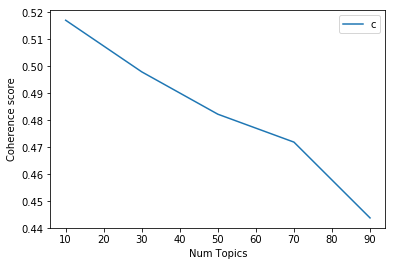

In [142]:
# Show graph
start=10; limit=100; step=20;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

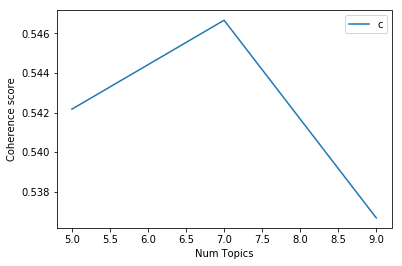

In [144]:
# Show graph
start=5; limit=10; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [145]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10)

In [294]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=50)

In [295]:
# Print the Keyword in the 50 topics
pprint(lda_model.print_topics())
#doc_lda = lda_model[corpus]

[(46,
  '0.056*"data" + 0.041*"tabl" + 0.035*"column" + 0.021*"row" + 0.019*"valu" + '
  '0.013*"select" + 0.013*"databas" + 0.013*"store" + 0.011*"one" + '
  '0.010*"group"'),
 (22,
  '0.255*"java" + 0.061*"org" + 0.034*"intern" + 0.024*"lang" + 0.019*"com" + '
  '0.017*"sun" + 0.015*"util" + 0.015*"apach" + 0.014*"except" + 0.013*"run"'),
 (17,
  '0.034*"time" + 0.032*"run" + 0.029*"thread" + 0.026*"process" + '
  '0.023*"call" + 0.022*"task" + 0.020*"start" + 0.015*"execut" + '
  '0.010*"block" + 0.009*"wait"'),
 (20,
  '0.037*"memori" + 0.020*"swift" + 0.017*"alloc" + 0.013*"self" + 0.013*"io" '
  '+ 0.012*"nsstring" + 0.010*"free" + 0.009*"cursor" + 0.009*"transform" + '
  '0.009*"custom"'),
 (32,
  '0.145*"id" + 0.072*"true" + 0.057*"fals" + 0.032*"return" + 0.025*"order" + '
  '0.018*"record" + 0.015*"null" + 0.014*"boolean" + 0.009*"categori" + '
  '0.009*"view"'),
 (41,
  '0.038*"window" + 0.035*"browser" + 0.033*"file" + 0.026*"chrome" + '
  '0.020*"ie" + 0.016*"firefox" + 0.

In [297]:
# Compute Perplexity for 50 topics
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score for 50 topics
coherence_model_lda = CoherenceModel(model=lda_model, texts=clean_train_questions[500:50000], dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.30446975124241

Coherence Score:  0.49115105968626227


In [298]:
# Visualize the 50 topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/anaconda3/lib/python3.6/site-packages/joblib/externals/loky/process_executor.py:686: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


PreparedData(topic_coordinates=           Freq  cluster  topics         x         y
topic                                               
5      8.880159        1       1 -0.226381 -0.104518
43     6.282557        1       2 -0.140674 -0.176413
46     3.320939        1       3 -0.183652 -0.030831
9      3.202078        1       4 -0.131498  0.069920
7      3.072625        1       5  0.111719 -0.196211
16     3.001294        1       6 -0.172995  0.078673
49     2.998709        1       7 -0.124112 -0.008636
17     2.841148        1       8 -0.115142 -0.099132
0      2.832894        1       9 -0.044087  0.148609
14     2.819502        1      10  0.095588 -0.099670
15     2.741704        1      11 -0.140415 -0.103836
31     2.606329        1      12  0.148279  0.128849
12     2.396616        1      13 -0.085112 -0.159957
11     2.238466        1      14  0.025242  0.063035
30     2.168488        1      15 -0.005921  0.024447
33     2.159853        1      16 -0.109374 -0.035280
19     2.094352        1      17 -0.125170  0.048176
45     2.070532        1      18 -0.115776  0.096138
2      2.039894        1      19  0.067712 -0.153733
22     2.017360        1      20  0.231762  0.036655
40     1.904985        1      21 -0.016874  0.097068
39     1.836869        1      22  0.064767 -0.151412
34     1.776408        1      23 -0.160705 -0.018686
26     1.738424        1      24 -0.058523  0.067937
35     1.692364        1      25  0.106464 -0.003051
23     1.687823        1      26 -0.027644  0.153702
24     1.523463        1      27  0.052144 -0.171342
28     1.500754        1      28  0.132231  0.166340
32     1.468148        1      29 -0.053167  0.147337
8      1.450000        1      30 -0.073115  0.032019
20     1.442687        1      31 -0.100498 -0.000060
10     1.427079        1      32  0.198422 -0.121881
29     1.388050        1      33 -0.077273  0.095982
42     1.372473        1      34  0.119767  0.043519
41     1.316952        1      35 -0.020209 -0.138832
6      1.291722        1      36  0.023317 -0.090156
27     1.272209        1      37  0.159195  0.041685
13     1.268459        1      38 -0.043150  0.125349
47     1.130488        1      39 -0.015061  0.018038
18     1.109191        1      40  0.110156  0.030149
37     1.011055        1      41  0.034022  0.062630
44     0.939203        1      42  0.096006 -0.017792
3      0.897622        1      43  0.039954 -0.019860
21     0.890144        1      44  0.064048  0.011637
4      0.886327        1      45  0.062403 -0.001542
48     0.868755        1      46  0.180779 -0.088869
36     0.820719        1      47  0.083235  0.067219
1      0.783589        1      48  0.075953  0.038461
38     0.766030        1      49  0.046002 -0.027726
25     0.752511        1      50  0.037362  0.125851, topic_info=      Category          Freq         Term         Total  loglift  logprob
term                                                                     
185    Default  19703.000000         java  19703.000000  30.0000  30.0000
472    Default  21508.000000      android  21508.000000  29.0000  29.0000
14     Default  17474.000000     function  17474.000000  28.0000  28.0000
226    Default  26545.000000         file  26545.000000  27.0000  27.0000
40     Default  11820.000000            c  11820.000000  26.0000  26.0000
171    Default  21056.000000        class  21056.000000  25.0000  25.0000
485    Default  12170.000000           id  12170.000000  24.0000  24.0000
249    Default  11530.000000         user  11530.000000  23.0000  23.0000
586    Default  12194.000000         test  12194.000000  22.0000  22.0000
143    Default  19265.000000       string  19265.000000  21.0000  21.0000
79     Default   8081.000000          div   8081.000000  20.0000  20.0000
373    Default  12633.000000       public  12633.000000  19.0000  19.0000
743    Default   8755.000000       system   8755.000000  18.0000  18.0000
260    Default  10532.000000          int  10532.000000  17.0000  17.0000
87     Default  1

In [296]:
#Pickled the model with joblib so that we can load it in the flask project
joblib.dump(lda_model, '/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/lda_model50.pkl')

['/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/lda_model50.pkl']

***
***

# Supervised learning

In this part, we will do some supervise learning. The steps are  the folowwing :
* create a matrice (Y) of the most frequent tags using 0 or 1
* slip the data to train and test
* supervise learning using : logistic regression and random forest (with the unlabelled examples and without the unlabelled examples)
* scoring will be done using f1score and the "weighted" average

In [4]:
def text_to_words_Y( raw_text ):
    # Remove non-letters        
    letters_only = re.sub("[^a-zA-Z C+ C#]", " ", raw_text) 
    #
    #Convert to lower case, split into individual words
    words = letters_only.lower().split()                                              
    #
    #Join the words back
    #return words
    return( " ".join(words))

In [440]:
text_to_words_Y(df["Tags"][50])

'java spring mvc post'

In [5]:
# Get the number of questions based on the dataframe column size
num_questions = df["Tags"].size
#num_questions = 5000

# Initialize an empty list to hold the clean questions
clean_tags = []

print("Cleaning and parsing the training...\n")
# Loop over each row; create an index i that goes from 0 to the length
# of the questions list 
for i in range(0, num_questions):
    # Call our function for each one, and add the result to the list of
    # clean questions
    clean_tags.append( text_to_words_Y( df["Tags"][i] ) )

Cleaning and parsing the training...



In [24]:
# Initialize the "CountVectorizer" object, which is scikit-learn's
# bag of words tool.  
tag_vectorizer = CountVectorizer(analyzer = "word",   
                             tokenizer = None,    
                             preprocessor = None, 
                             stop_words = None,   
                             max_features = 50) 

# fit_transform() does two functions: First, it fits the model
# and learns the vocabulary; second, it transforms our training data
# into feature vectors. The input to fit_transform should be a list of 
# strings.
tags_features_NA = tag_vectorizer.fit_transform(clean_tags)

# Numpy arrays are easy to work with, so convert the result to an 
# array
tags_features = tags_features_NA.toarray()

In [28]:
tag_vocab = tag_vectorizer.get_feature_names()
tag_dist = np.sum(tags_features, axis=0)

In [29]:
tag_Frequence = pd.DataFrame()
tag_Frequence['Tags'] = tag_vocab
tag_Frequence['occurrence'] = tag_dist
tag_Frequence.sort_values(by=['occurrence'], inplace=True, ascending=False)

In [30]:
tag_Frequence.head()

,Tags,occurrence
0,android,6115
21,java,5187
22,javascript,4453
30,net,4282
36,python,4276


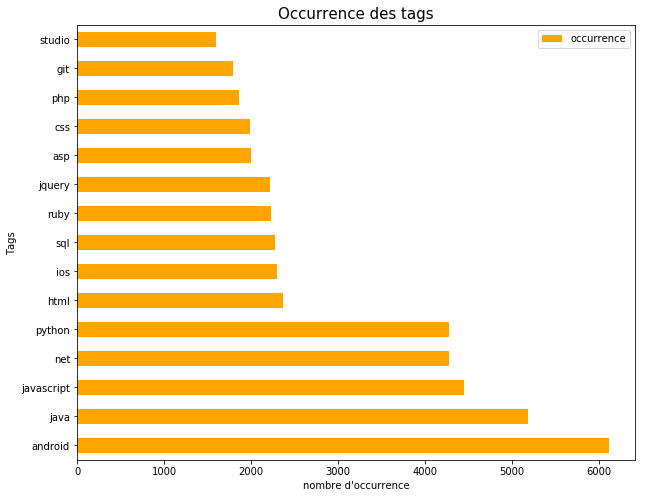

In [32]:
tag_Frequence.head(15).plot(kind = 'barh', x = tag_Frequence.head(15)['Tags'], figsize = (10,8), color = 'orange')
plt.xlabel("nombre d'occurrence")
plt.title('Occurrence des tags', size = 15)
plt.rcParams.update({'font.size': 15})
plt.show()

In [33]:
tag_Frequence.occurrence.describe()

count      50.000000
mean     1472.600000
std      1289.640133
min       468.000000
25%       652.750000
50%      1012.500000
75%      1847.000000
max      6115.000000
Name: occurrence, dtype: float64

In [34]:
TagsColumns = pd.DataFrame(tags_features)

In [35]:
TagsColumns.columns = TagsColumns.columns[:0].tolist() + tag_vocab

In [36]:
TagsColumns = TagsColumns.astype(bool).astype(int)

In [38]:
dfTags = pd.concat([df, TagsColumns],axis=1)

In [40]:
dfTags.drop(['Id','Title','Body','Score','ViewCount','Tags'], axis=1, inplace=True)

In [41]:
dfTags.shape

(50000, 51)

In [42]:
dfTags.drop(dfTags.index[[400,500]], inplace=True)

In [45]:
dfTags["Text"] = dfTags["Text"].map(lambda x : text_to_words(x))

In [46]:
dfTags.head()

,Text,android,angularjs,api,arrays,asp,bash,cocoa,css,data,...,spring,sql,string,studio,swift,testing,visual,web,windows,xcode
0,preparedstat statement return generat key onli...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,upload display save imag node js express uploa...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,python split list base condit best way aesthet...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,veloc editor plugin eclips seen veloedit seem ...,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,proguard reflect android proguard class tri in...,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
dfTags["Text"].isnull().sum()

2

In [5]:
dfTags.dropna(axis=0,inplace=True)
print(dfTags.shape)

Text(0.5,0,'# of categories')

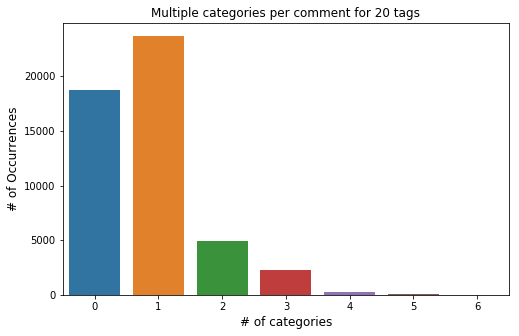

In [13]:
rowsums = dfTags.iloc[:,1:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment for 20 tags")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [23]:
print("for 20 tags\n",x/dfTags.shape[0])

for 20 tags
 1    0.473818
0    0.375570
2    0.097808
3    0.045444
4    0.005900
5    0.001340
6    0.000120
dtype: float64


Text(0.5,0,'# of categories')

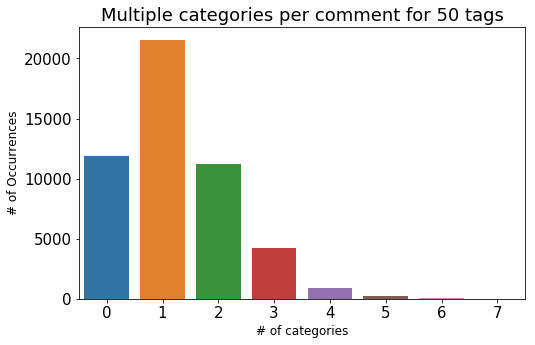

In [51]:
rowsums = dfTags.iloc[:,1:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment for 50 tags")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [53]:
print("for 50 tags\n",x/dfTags.shape[0])

for 50 tags
 1    0.430737
0    0.236829
2    0.224029
3    0.084843
4    0.018761
5    0.003860
6    0.000800
7    0.000140
dtype: float64


In [106]:
Y = dfTags.copy()

In [110]:
# removed unlabelled examples
Y = Y[(Y.iloc[:,1:].sum(axis=1)) != 0]

Text(0.5,0,'# of categories')

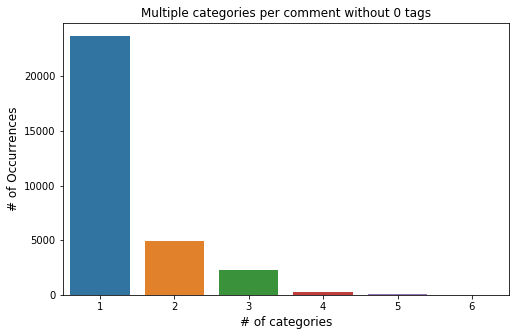

In [111]:
rowsums = Y.iloc[:,1:].sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment without 0 tags")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [113]:
X = Y.Text

In [114]:
Y.drop(["Text"], axis=1, inplace=True)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [117]:
#Random selection of train and test
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, Y,
                                                                    test_size=0.3 
                                                                    # 30% of the data in test set
                                                                   )

In [118]:
# distibution of y for train and test sets

print('Training class distributions : {}'.format(sorted(y_train.sum(axis=0))))
print('Test class distributions : {}'.format(sorted(y_test.sum(axis=0))))

Training class distributions : [657, 743, 762, 773, 776, 906, 937, 1026, 1120, 1127, 1150, 1269, 1356, 1369, 1540, 2366, 2540, 2598, 3107, 3300]
Test class distributions : [290, 291, 293, 295, 336, 382, 414, 437, 448, 456, 461, 530, 537, 571, 629, 1004, 1166, 1171, 1236, 1467]


In [139]:
tag_vocab = Y.columns.values

## Logistic Regression with unlabelled examples

### for 20 tags

In [186]:
tdf = TfidfVectorizer()
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)

steps = [('tdf', tdf),
        ('LogReg', clf)]

pipeline = Pipeline(steps)


In [187]:
pipeline.fit( X_train, y_train)


Pipeline(memory=None,
     steps=[('tdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ..._state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [188]:
y_pred = pipeline.predict( X_test)

In [190]:
#Classification report
##values of f1-score in the report correspond to the sklearn.metrics.f1_score with "binary' average for each examples
report = metrics.classification_report( y_test, y_pred) #http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html
print(report)

             precision    recall  f1-score   support

          0       0.98      0.75      0.85      1109
          1       0.91      0.50      0.65       420
          2       0.90      0.62      0.73       490
          3       0.95      0.82      0.88       402
          4       0.68      0.33      0.45       613
          5       0.77      0.45      0.57       594
          6       0.86      0.53      0.66      1416
          7       0.79      0.51      0.62      1344
          8       0.87      0.62      0.72       542
          9       0.85      0.42      0.56       353
         10       0.88      0.42      0.57       282
         11       0.84      0.39      0.53       995
         12       0.93      0.53      0.67       320
         13       0.90      0.53      0.66       520
         14       0.95      0.66      0.78      1126
         15       0.93      0.53      0.67       315
         16       0.97      0.56      0.71       465
         17       0.80      0.51      0.63   

In [191]:
prediction_df = pd.DataFrame(columns=Y.columns,
                             data=y_pred)

In [3]:
# To see the accuracy for each label
for category in tag_vocab:
    print(metrics.accuracy_score(y_test.as_matrix([category]), prediction_df.as_matrix([category])))

In [171]:
metrics.f1_score(y_test, y_pred, average='weighted')

### for 50 tags

In [60]:
#define pipeline for logisitc regression
tdf = TfidfVectorizer()
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)
#balance = RandomUnderSampler() #http://contrib.scikit-learn.org/imbalanced-learn/stable/auto_examples/applications/plot_topic_classication.html

steps = [('tdf', tdf),
        ('LogReg', clf)]

pipeline = Pipeline(steps)

In [61]:
pipeline.fit( X_train, y_train)

Pipeline(memory=None,
     steps=[('tdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ..._state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [62]:
y_pred = pipeline.predict( X_test)

In [63]:
report = metrics.classification_report( y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.99      0.73      0.84      1103
          1       0.95      0.58      0.72       219
          2       0.63      0.19      0.30       139
          3       0.71      0.35      0.46       237
          4       0.90      0.45      0.60       446
          5       0.86      0.39      0.54       181
          6       1.00      0.01      0.01       136
          7       0.86      0.61      0.71       478
          8       0.62      0.03      0.06       154
          9       0.50      0.09      0.15       163
         10       0.83      0.10      0.18       149
         11       0.96      0.62      0.75       158
         12       0.92      0.59      0.72       186
         13       0.67      0.18      0.28       169
         14       0.93      0.32      0.48       115
         15       0.95      0.84      0.89       400
         16       0.85      0.45      0.59       241
         17       0.70      0.38      0.50   

In [64]:
Y.columns.values

array(['android', 'angularjs', 'api', 'arrays', 'asp', 'bash', 'cocoa',
       'css', 'data', 'database', 'design', 'django', 'eclipse', 'file',
       'framework', 'git', 'google', 'html', 'http', 'ios', 'iphone',
       'java', 'javascript', 'jquery', 'js', 'json', 'linux', 'macos',
       'mvc', 'mysql', 'net', 'node', 'objective', 'on', 'performance',
       'php', 'python', 'rails', 'ruby', 'server', 'spring', 'sql',
       'string', 'studio', 'swift', 'testing', 'visual', 'web', 'windows',
       'xcode'], dtype=object)

## Logistic Regression without unlabelled examples

### for 20 tags

In [194]:
tdf = TfidfVectorizer()
clf = OneVsRestClassifier(LogisticRegression(solver='sag'), n_jobs=1)

steps = [('tdf', tdf),
        ('LogReg', clf)]

pipeline = Pipeline(steps)


In [195]:
pipeline.fit( X_train, y_train)


Pipeline(memory=None,
     steps=[('tdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ..._state=None, solver='sag', tol=0.0001,
          verbose=0, warm_start=False),
          n_jobs=1))])

In [252]:
#Pickled the model with joblib so that we can load it in the flask project
joblib.dump(pipeline, '/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/LogisitcReg.pkl')

['/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/LogisitcReg.pkl']

In [253]:
joblib.dump(tag_vocab, '/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/tag_vocab.pkl')

['/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/tag_vocab.pkl']

In [228]:
y_pred = pipeline.predict( X_test)

In [229]:
#lets look at the f1 score using the classification report
#each line represent a label (in the ordre of Y columns)
report = metrics.classification_report( y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       0.99      0.78      0.87      1171
          1       0.95      0.50      0.66       461
          2       0.91      0.63      0.74       437
          3       0.99      0.84      0.91       414
          4       0.66      0.40      0.50       571
          5       0.98      0.66      0.79       629
          6       0.91      0.66      0.76      1467
          7       0.84      0.59      0.69      1236
          8       0.90      0.57      0.70       537
          9       0.92      0.49      0.64       336
         10       0.92      0.44      0.59       295
         11       0.95      0.54      0.69      1004
         12       0.94      0.55      0.69       293
         13       0.95      0.56      0.71       530
         14       0.99      0.76      0.86      1166
         15       0.94      0.55      0.70       291
         16       0.99      0.60      0.75       456
         17       0.91      0.69      0.78   

In [168]:
#values of f1-score in the report correspond to the sklearn.metrics.f1_score with "binary' average for each examples
for category in tag_vocab:
    print(metrics.f1_score(y_test.as_matrix([category]), prediction_df.as_matrix([category]), average='binary'))

0.871647509578544
0.6572237960339943
0.7449392712550607
0.9074315514993482
0.5
0.7855100095328884
0.7635643564356436
0.6933333333333334
0.6978335233751425
0.6381322957198443
0.5931034482758621
0.6895238095238095
0.6939655172413792
0.7076923076923076
0.8603297769156159
0.6969696969696971
0.746922024623803
0.7801778907242692
0.7503875968992246
0.7422680412371133


In [172]:
#average of the report corespond to sklearn.metrics.f1_score with "weihted' average
metrics.f1_score(y_test, y_pred, average='weighted')

0.7422570616585991

Text(0.5,0,'# of categories')

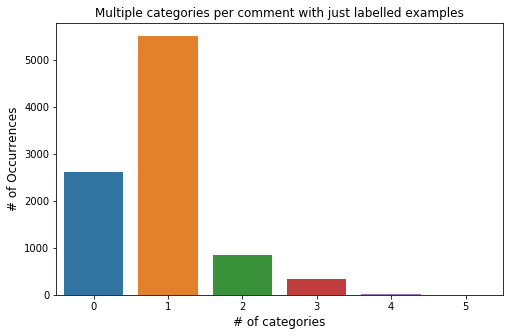

In [165]:
prediction_df = pd.DataFrame(columns=Y.columns,
                             data=y_pred)

rowsums = prediction_df.sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment with just labelled examples")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

Text(0.5,0,'# of categories')

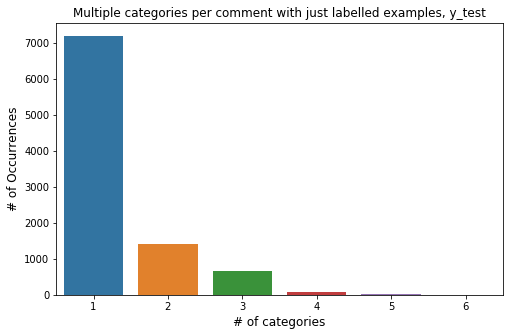

In [151]:
rowsums =y_test.sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment with just labelled examples, y_test")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

Work on prediction proba

In [214]:
y_pred_proba = pipeline.predict_proba( X_test)

In [239]:
prediction_df_adjust = pd.DataFrame(columns=Y.columns,
                                    data=y_pred_proba)

In [218]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

In [252]:
#Pickled the model with joblib so that we can load it in the flask project

joblib.dump(adjustClasses, '/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/LogisitcReg.pkl')

['/Users/anita/Documents/FormationDataScientist/Projet_StackOverflow/test_Flask/LogisitcReg.pkl']

In [240]:
y_pred_proba_adj = pd.DataFrame()
for category in tag_vocab:
    y_pred_proba_adj[category] = adjusted_classes(prediction_df_adjust[category], 0.3)

Text(0.5,0,'# of categories')

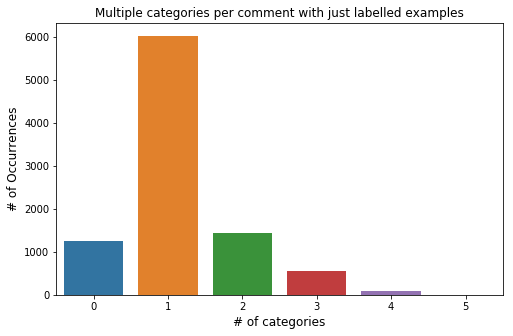

In [241]:
rowsums = y_pred_proba_adj.sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment with just labelled examples")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [242]:
report = metrics.classification_report( y_test, y_pred_proba_adj)
print(report)

             precision    recall  f1-score   support

          0       0.98      0.87      0.92      1171
          1       0.90      0.65      0.76       461
          2       0.82      0.78      0.80       437
          3       0.99      0.91      0.95       414
          4       0.59      0.65      0.62       571
          5       0.95      0.79      0.87       629
          6       0.84      0.80      0.82      1467
          7       0.76      0.78      0.77      1236
          8       0.85      0.72      0.78       537
          9       0.87      0.63      0.73       336
         10       0.83      0.59      0.69       295
         11       0.88      0.71      0.78      1004
         12       0.93      0.68      0.78       293
         13       0.91      0.70      0.79       530
         14       0.97      0.88      0.92      1166
         15       0.94      0.67      0.78       291
         16       0.99      0.73      0.84       456
         17       0.86      0.81      0.83   

In [225]:
y_pred_proba_adj = pd.DataFrame()
for category in tag_vocab:
    y_pred_proba_adj[category] = adjusted_classes(prediction_df_adjust[category], 0.2)

Text(0.5,0,'# of categories')

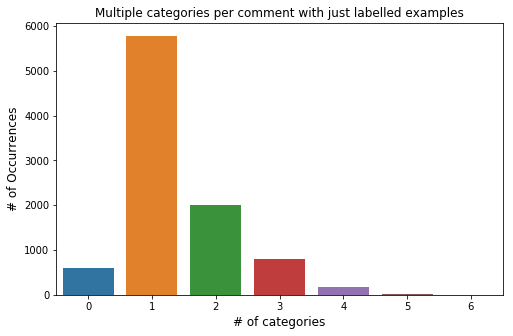

In [226]:
rowsums = y_pred_proba_adj.sum(axis=1)
x=rowsums.value_counts()

#plot
plt.figure(figsize=(8,5))
ax = sns.barplot(x.index, x.values)
plt.title("Multiple categories per comment with just labelled examples")
plt.ylabel('# of Occurrences', fontsize=12)
plt.xlabel('# of categories', fontsize=12)

In [227]:
#lets look at the f1 score using the classification report
#each line represent a label (in the ordre of Y columns)
report = metrics.classification_report( y_test, y_pred_proba_adj)
print(report)

             precision    recall  f1-score   support

          0       0.94      0.92      0.93      1171
          1       0.83      0.74      0.78       461
          2       0.76      0.86      0.81       437
          3       0.98      0.94      0.96       414
          4       0.52      0.76      0.62       571
          5       0.91      0.86      0.88       629
          6       0.75      0.88      0.81      1467
          7       0.68      0.87      0.76      1236
          8       0.77      0.80      0.79       537
          9       0.83      0.68      0.75       336
         10       0.75      0.68      0.71       295
         11       0.76      0.82      0.79      1004
         12       0.89      0.75      0.81       293
         13       0.87      0.79      0.83       530
         14       0.94      0.93      0.94      1166
         15       0.89      0.75      0.81       291
         16       0.97      0.81      0.88       456
         17       0.79      0.86      0.83   

## Random Forest with unlabelled examples

In [175]:
tdf = TfidfVectorizer()
forest = RandomForestClassifier(criterion='entropy', n_jobs=-1)
#n_estimators=100, min_samples_split=3

steps = [('tdf', tdf),
        ('random_forest', forest)]

pipeline = Pipeline(steps)


In [4]:
parameters = dict(random_forest__n_estimators=[100, 200, 300],
                  #random_forest__max_depth=[2, 4],
                  random_forest__min_samples_split=[3, 5])

rf_cv = GridSearchCV(pipeline, param_grid=parameters, cv=3, scoring='f1_weighted')

rf_cv.fit(X_train, y_train)

In [47]:
print(rf_cv.best_params_)

{'random_forest__min_samples_split': 3, 'random_forest__n_estimators': 100}


In [60]:
y_pred = rf_cv.predict( X_test)

In [61]:
report = metrics.classification_report( y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       1.00      0.34      0.51      1087
          1       0.94      0.07      0.13       469
          2       0.96      0.19      0.32       467
          3       0.98      0.39      0.56       423
          4       0.75      0.00      0.01       621
          5       0.88      0.04      0.07       605
          6       0.96      0.12      0.22      1370
          7       0.96      0.10      0.18      1303
          8       1.00      0.03      0.06       593
          9       1.00      0.01      0.03       313
         10       1.00      0.01      0.03       305
         11       0.95      0.08      0.15      1067
         12       0.94      0.05      0.09       307
         13       1.00      0.03      0.06       534
         14       0.98      0.25      0.40      1095
         15       0.94      0.05      0.09       301
         16       0.95      0.15      0.26       483
         17       0.97      0.13      0.23   

## Random Forest without unlabelled examples

In [186]:
tdf = TfidfVectorizer()
forest = RandomForestClassifier(criterion='entropy', n_jobs=-1)
#n_estimators=200, min_samples_split=3, 

steps = [('tdf', tdf),
        ('random_forest', forest)]

pipeline = Pipeline(steps)
#pipeline.fit( X_train, y_train)

In [187]:
parameters = dict(random_forest__n_estimators=[100, 200, 300],
                  #random_forest__max_depth=[2, 4],
                  random_forest__min_samples_split=[3, 5])

rf_cv = GridSearchCV(pipeline, param_grid=parameters, cv=3, scoring='f1_weighted')

rf_cv.fit(X_train, y_train)

/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


GridSearchCV(cv=3, error_score='raise',
       estimator=Pipeline(memory=None,
     steps=[('tdf', TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
   ..._jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False))]),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'random_forest__n_estimators': [100, 200, 300], 'random_forest__min_samples_split': [3, 5]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=0)

In [188]:
print(rf_cv.best_params_)

{'random_forest__min_samples_split': 3, 'random_forest__n_estimators': 200}


In [191]:
y_pred = rf_cv.predict( X_test)

In [193]:
report = metrics.classification_report( y_test, y_pred)
print(report)

             precision    recall  f1-score   support

          0       1.00      0.50      0.67      1171
          1       0.99      0.18      0.30       461
          2       0.95      0.36      0.53       437
          3       0.99      0.68      0.80       414
          4       0.78      0.05      0.10       571
          5       1.00      0.19      0.32       629
          6       0.98      0.37      0.54      1467
          7       0.95      0.24      0.38      1236
          8       0.98      0.10      0.19       537
          9       1.00      0.08      0.15       336
         10       1.00      0.05      0.10       295
         11       0.98      0.22      0.35      1004
         12       0.98      0.17      0.29       293
         13       1.00      0.06      0.12       530
         14       1.00      0.50      0.67      1166
         15       0.98      0.17      0.29       291
         16       1.00      0.28      0.44       456
         17       0.95      0.46      0.62   

***